In [1]:
from searcher import TableSearcher
from translator import Translator
from nltk.metrics.distance import edit_distance
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from collections import defaultdict
import pandas as pd
%matplotlib inline

In [2]:
searcher = TableSearcher('big_table.txt')
traslator = Translator('../data/raw_data/')

Была посчитана таблица, в которой для каждого слова иврита из датасета найдены 100 ближайших по расстоянию левенштейна слов. Посмотрим на результат.

In [3]:
with open('big_table.txt') as handler:
    words = []
    for line in handler:
        words.extend(line.strip().split())
words = list(set(words))

In [4]:
word = words[6]
nearests = searcher.search(word)
pd.DataFrame({
    '1_src word': [word for _ in nearests],
    '2_dst word': nearests,
    '3_levenshtein': [
        edit_distance(nearest, word)
        for nearest in nearests
    ]
})

,1_src word,2_dst word,3_levenshtein
0,וטיוח,וריוח,1
1,וטיוח,לטיוח,1
2,וטיוח,וטוח,1
3,וטיוח,אטיות,2
4,וטיוח,בטווח,2
5,וטיוח,בטיול,2
6,וטיוח,בריוח,2
7,וטיוח,הטיול,2
8,וטיוח,הטיות,2
9,וטיוח,ואחוח,2


Для этого слова иврита $word$ есть $99$ ближайших слов иврита $nearest_i(word)$. Обозначим $translate(word)$ - множество транслитераций слова иврита $word$, $levenshtein(word\_1, word\_2)$ - расстояние Левенштейна между словами $word\_1$ и $word\_2$.

Зафиксируем $w$ - слово иврита, $j$ - число от 1 до 99. Для всех возможных пар $(t\_1, t\_2)$, где $t\_1$ - некоторая транслитерация $w$, $t_2$ - некоторая транслитерация $nearest\_j(w)$ посчитаем среднее значение $levenshein(t\_1, t\_2)$. Получено значение $f(w, j)$. Построим график зависимости $levenshtein(w, nearest_i(w))$ от $f(w, i)$ с усреднением по всем словам. Этот график иллюстрирует, насколько расстояние левенштейна между словами иврита коррелирует с расстоянием левенштейна между соответствующими им переводами. Ожидавется, что этот график монотонно возрастает.

In [5]:
def update_statistic(word, statistics):
    nearests = searcher.search(word)
    word_traslations = traslator.translate_all(word)
    nearests_translations = [
        traslator.translate_all(nearest)
        for nearest in nearests
    ]
    nearests_levenshteins = [
        edit_distance(word, nearest)
        for nearest in nearests
    ]
    nearests_translations_levenshteins = [
        np.mean([
            edit_distance(word_traslation, newrest_traslation)
            for newrest_traslation in nearest_traslations
            for word_traslation in word_traslations
        ])
        for nearest_traslations in nearests_translations
    ]
    levenshteins = sorted(list(set(nearests_levenshteins)))
    for nearests_levenshtein, nearests_translations_levenshtein in zip(
        nearests_levenshteins, nearests_translations_levenshteins
    ):
        statistics[nearests_levenshtein].append(nearests_translations_levenshtein)

In [6]:
%%time
statistics = defaultdict(list)
for word in words:
    statistic = update_statistic(word, statistics)

CPU times: user 1h 10min 21s, sys: 1.85 s, total: 1h 10min 23s
Wall time: 1h 10min 37s


In [7]:
x = sorted(list(statistics.keys()))
y = [np.mean(statistics[key]) for key in x]
errors = [np.std(statistics[key]) for key in x]

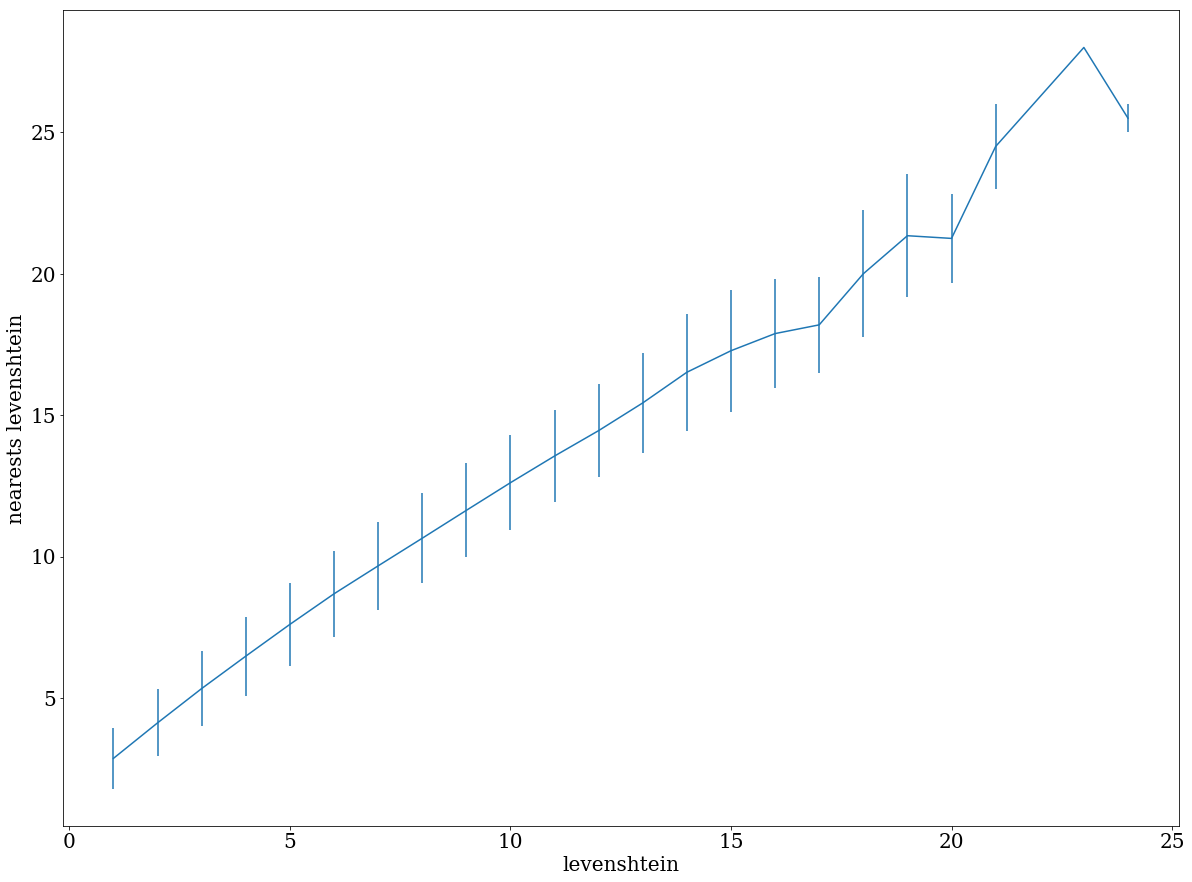

In [8]:
matplotlib.rc('font', family='serif', size=20)
plt.figure(figsize=(20, 15))
plt.errorbar(x, y, yerr=errors)
plt.xlabel('levenshtein')
plt.ylabel('nearests levenshtein')
plt.show()

Гравик действительно монотонно возрастает.